In [265]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import argparse
from math import sqrt
from __future__ import print_function

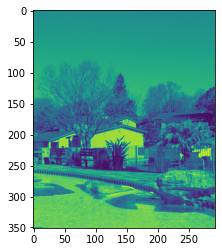

In [266]:
imgR = cv2.imread('C:/Users/ahnaf/Documents/Jupyter Notebook/image_stitching/right.jpg')
imgR2 = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)
#cv2.imwrite("right.jpg", imgR2)
#cv2.imshow("right.jpg", imgR2)
#cv2.waitKey()
plt.imshow(imgR2)
plt.show()

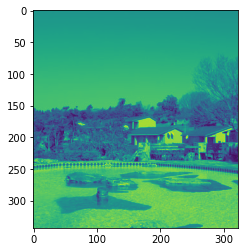

In [267]:
imgL = cv2.imread('C:/Users/ahnaf/Documents/Jupyter Notebook/image_stitching/left.jpg')
imgL2 = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
#cv2.imwrite("left.jpg", imgL2)
#cv2.imshow("leftt.jpg", imgL2)
#cv2.waitKey()
plt.imshow(imgL2)
plt.show()



In [268]:
akaze = cv2.AKAZE_create()
#find key points
keypoints_L, descriptors_L = akaze.detectAndCompute(imgL2,None)
keypoints_R, descriptors_R = akaze.detectAndCompute(imgR2,None)


In [269]:
len(keypoints_R)

363

In [270]:
len(keypoints_L)

335

In [271]:
len(matches2)

130

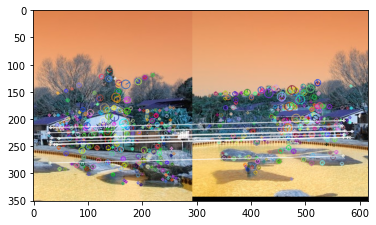

In [272]:
#feature matching

match = cv2.BFMatcher()
matches = match.knnMatch(descriptors_R,descriptors_L,k=2)

good = []
for m,n in matches:
    if m.distance < 0.03*n.distance:
        good.append(m)

draw_parameters = dict(matchColor=(255,255,255),
                       singlePointColor=None,
                       flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

img3 = cv2.drawMatches(imgR,keypoints_R,imgL,keypoints_L,good,None,**draw_parameters)

#cv2.imshow("feature_detected_akaze.png", img3)
#cv2.waitKey()
plt.imshow(img3)

plt.savefig('feature_detected_akaze.png')
plt.show()




In [273]:
len(good)

9

In [274]:
len(matches)

363

In [275]:
MIN_MATCH_COUNT = 9
if len(good) > MIN_MATCH_COUNT:
    src_pts = np.float32([ keypoints_R[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ keypoints_L[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    h,w = imgR2.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts, M)
    imgLR = cv2.polylines(imgL2,[np.int32(dst)],True,1,3, cv2.LINE_AA)
    
    plt.imshow(imgLR)
    plt.savefig('transform_AKAZE.png')
    plt.show()
    
else:
    print("Not enought matches are found - %d/%d", (len(good)/MIN_MATCH_COUNT))

Not enought matches are found - %d/%d 1.0


In [276]:
matched1 = []
matched2 = []

for m, n in matches:
    if m.distance < 0.03 * n.distance:
        matched1.append(keypoints_R[m.queryIdx])
        matched2.append(keypoints_L[m.trainIdx])

In [277]:
len(matched1)

9

In [278]:
inliers1 = []
inliers2 = []
good_matches = []
inlier_threshold = 2.5 # Distance threshold to identify inliers with homography check
for i, m in enumerate(matched1):
    col = np.ones((3,1), dtype=np.float64)
    col[0:2,0] = m.pt

    col = np.dot(M, col)
    col /= col[2,0]
    dist = sqrt(pow(col[0,0] - matched2[i].pt[0], 2) +\
                pow(col[1,0] - matched2[i].pt[1], 2))

    if dist < inlier_threshold:
        good_matches.append(cv2.DMatch(len(inliers1), len(inliers2), 0))
        inliers1.append(matched1[i])
        inliers2.append(matched2[i])

In [279]:
len(inliers1)

9

In [280]:
len(inliers2)

9

In [281]:
len(src_pts)


10

In [282]:
len(dst_pts)

10

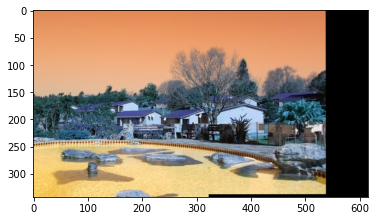

In [283]:
warped_image = cv2.warpPerspective(imgR,M,(imgL.shape[1] + imgR.shape[1], imgL.shape[0]))
warped_image[0:imgL.shape[0], 0:imgL.shape[1]] = imgL

plt.imshow(warped_image)
#cv2.imshow("warped_image_akaze.png", warped_image)
#cv2.waitKey()
plt.savefig('warped_image_akaze.png')
plt.show()


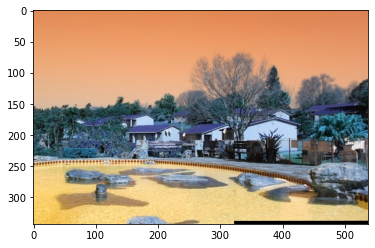

In [284]:

def trim(frame):
    #crop top
    if not np.sum(frame[0]):
        return trim(frame[1:])
    #crop bottom
    elif not np.sum(frame[-1]):
        return trim(frame[:-2])
    #crop left
    elif not np.sum(frame[:,0]):
        return trim(frame[:,1:]) 
    #crop right
    elif not np.sum(frame[:,-1]):
        return trim(frame[:,:-2])    
    return frame

#cv2.imshow("Stitched_AKAZE.png", trim(warped_image))
#cv2.waitKey()
        
plt.imshow(trim(warped_image))
plt.savefig('Stitched_AKAZE.png')

plt.show()  


In [285]:
inlier_ratio = len(inliers1) / float(len(matched1))
print('A-KAZE Matching Results')
print('*******************************')
print('# Keypoints 1:                        \t', len(keypoints_R))
print('# Keypoints 2:                        \t', len(keypoints_L))
print('# Matches:                            \t', len(matched1))
print('# Inliers:                            \t', len(inliers1))
print('# Inliers Ratio:                      \t', inlier_ratio)


A-KAZE Matching Results
*******************************
# Keypoints 1:                        	 363
# Keypoints 2:                        	 335
# Matches:                            	 9
# Inliers:                            	 9
# Inliers Ratio:                      	 1.0
